<a href="https://colab.research.google.com/github/FariusGitHub/DataScience/blob/master/stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elasticsearch for Stackoverflow Knowledge Base
Farius Tjioesman, April 29, 2021 - ftjioesman@yahoo.com

Following Dakshina work and suggestion from Shaohua I continue this Knowledge <br> base on Similiarity analysis with indexing and querying from ElasticSearch
that using <br> using BM25 by default (almost similar to traditional TF-IDF). Based on cleaned data <br> from Dakshina we half almost half a million row data left<br> 

Coding below was inspired from Anirudh Dey August 2020 article.

https://codeburst.io/deconstructing-scoring-in-elasticsearch-e8544676a24

The elasticseach score was derived from the multiplication of three components <br> Boost factor, idf factor and tf factor. Boost factor is 2.2 by default.

Herewith is the formula for tf

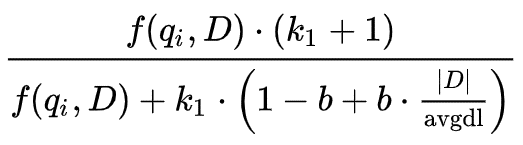

And Herewith is the formula for idf 

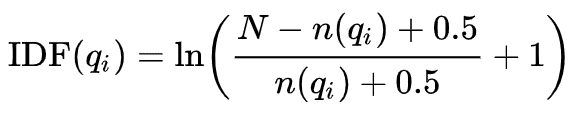

In [1]:
from time import sleep

In [6]:
# install es server
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q --show-progress
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0

elasticsearch-7.0.0 100%[===================>] 330.70M  77.1MB/s    in 4.3s    


In [7]:
# The server may take some time prior to get response from Virtual Environment
sleep(60)

In [8]:
# start server and check es virtual machine connection
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# wait a bit then test, if failed than re-run this cell
!curl -X GET "localhost:9200/"

{
  "name" : "59036e34367b",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "iaIbAYEBRZaZSYyE1lSlsQ",
  "version" : {
    "number" : "7.0.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "b7e28a7",
    "build_date" : "2019-04-05T22:55:32.697037Z",
    "build_snapshot" : false,
    "lucene_version" : "8.0.0",
    "minimum_wire_compatibility_version" : "6.7.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [9]:
# client-side
!pip install elasticsearch -q
from tqdm import tqdm
import sys
import json
from pprint import pprint
# Import Elasticsearch package 
from elasticsearch import Elasticsearch 
es = Elasticsearch()
es.ping()  # got True

True

In [12]:
#Extract data 
import pandas as pd
docs=pd.read_csv('https://farius.s3.us-east-2.amazonaws.com/EV3/bigdata/482774.csv')
# docs=pd.read_csv('https://farius.s3.us-east-2.amazonaws.com/EV3/bigdata/Dakshina_482774.csv') 

In [13]:
docs

,_id,text
0,62073693,trying wrtie two txtfiles test txt test txt cs...
1,62073724,train model using linear regression used print...
2,62073806,completely preprocess mnist dataset feeding cn...
3,62073823,webratio javhttps registry hub docker com r we...
4,62074040,following dataframe df index df date df groupb...
...,...,...
482769,104983,python specifically variables get shared threa...
482770,105212,suppose directory dir inside symlinks director...
482771,105546,got loads options php mysql apache combo best ...
482772,106850,trying write console terminal gaming console p...


In [18]:
#Ingesting documents into Elasticsearch at Google Colab (take a minute)
for i in tqdm(range(len(docs))):
    
    request_body = {
    "settings": {
        "number_of_shards": 5,
        "number_of_replicas": 1
    },
    'mappings': {
        'examplecase': {
            'properties': {
                'tbl_id': {'type': 'keyword'},
                'texts': {'type': 'text'},
            }
        }
    },
    'id' : docs.iloc[i][0],
    'text_entry' : docs.iloc[i][1]
    }
    
    es.index(index='stackoverflow', doc_type='Blog', id=i+1, body=request_body)

  0%|          | 0/482774 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document index requests is deprecated, use the typeless endpoints instead (/{index}/_doc/{id}, /{index}/_doc, or /{index}/_create/{id}).
  warnings.warn(message, category=ElasticsearchWarning)
100%|██████████| 482774/482774 [1:27:36<00:00, 91.84it/s]


In [19]:
# Checking data integrity
!curl -X GET 'http://localhost:9200/stackoverflow/_count?pretty'

{
  "count" : 482774,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  }
}


Using .search and enabling explaination (explain=True) we can follow along <br> how _score was computed

Reference : <br>
https://marcobonzanini.com/2015/02/02/how-to-query-elasticsearch-with-python/ <br>
https://www.mathworks.com/help///textanalytics/ref/bagofwords.tfidf.html <br>
https://en.wikipedia.org/wiki/Okapi_BM25


In [111]:
query_word='elasticsearch instance databricks spark'
#display the top 10 query for a word query_word above
result=es.search(index="stackoverflow", explain=True, size=10, doc_type="Blog",\
                 body={"query": {"match": {"text_entry": query_word}}})
result

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_explanation': {'description': 'sum of:',
     'details': [{'description': 'weight(text_entry:elasticsearch in 40055) [PerFieldSimilarity], result of:',
       'details': [{'description': 'score(freq=4.0), product of:',
         'details': [{'description': 'boost', 'details': [], 'value': 2.2},
          {'description': 'idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:',
           'details': [{'description': 'n, number of documents containing term',
             'details': [],
             'value': 1143},
            {'description': 'N, total number of documents with field',
             'details': [],
             'value': 482774}],
           'value': 6.045457},
          {'description': 'tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:',
           'details': [{'description': 'freq, occurrences of term within document',
             'details': [],
             'val

In [112]:
#to extract _score of first the result
result['hits']['hits'][0]['_explanation']['details'][0]['value']

10.732946

In [113]:
#to extract boost component of the first result
result['hits']['hits'][0]['_explanation']['details'][0]['details']\
  [0]['details'][0]['value']

2.2

In [114]:
#to extract idf component of first result
result['hits']['hits'][0]['_explanation']['details'][0]['details']\
  [0]['details'][1]['value']

6.045457

In [115]:
#to extract tf component of first result
result['hits']['hits'][0]['_explanation']['details'][0]['details']\
  [0]['details'][2]['value']

0.80698806

In [118]:
#checking the formula consistency for 10 query found from query_word

print("Similarity Analysis for the phrase'", query_word,"'")

for i in range(len(result['hits']['hits'])):
    
    score = result['hits']['hits'][i]['_explanation']['details'][0]\
            ['value']
    boost = result['hits']['hits'][i]['_explanation']['details'][0]\
            ['details'][0]['details'][0]['value'] 
    idf  =  result['hits']['hits'][i]['_explanation']['details'][0]\
            ['details'][0]['details'][1]['value'] 
    tf   =  result['hits']['hits'][i]['_explanation']['details'][0]\
            ['details'][0]['details'][2]['value']

    text =  result['hits']['hits'][i]['_source']['text_entry']
    
    print('document id = ',result['hits']['hits'][i]['_id'])
    print('score = ',score, '=', boost, '*', idf, '*', tf, '--> error=',\
          boost*idf*tf-score)
    print('document content: ', result['hits']['hits'][i]['_source']['text_entry'],'\n')

Similarity Analysis for the phrase' elasticsearch instance databricks spark '
document id =  42157
score =  10.732946 = 2.2 * 6.045457 * 0.80698806 --> error= -4.4426447409762204e-07
document content:  trying index data elasticsearch databricks using pyspark works configuration scala trying write es using pyspark fails needed based transforms using python packages esconf esconf es nodes wan true esconf es port esconf es net ssl true esconf es read metadata true esconf es nodes esurl esconf ex index auto create true esconf es resource auto create geohashing testing geocordsschema write format org elasticsearch spark sql options esconf mode overwrite save geohash test error produced org elasticsearch hadoop eshadoopillegalargumentexception detect es version typically happens network elasticsearch cluster accessible targeting wan cloud instance without proper setting apos es nodes wan apos ideas suggestions missing config would work scala using pyspark 

document id =  278687
score =  11.

Check below link for futher module similarity with classic scoring
https://www.elastic.co/guide/en/elasticsearch/reference/current/index-modules-similarity.html